# Введение

Перед нами, как аналитиком интернет-магазина, поставлена задача увеличить выручку. Для этого были выдвинуты несколько предложений, которые нужно рассмотреть, провести А/В тест и по результатам принять решение.

    
Для работы предоставлены выгрузки: "/datasets/hypothesis.csv", где лежат 9 гипотез по увеличению выручки интернет-магазина, "/datasets/orders.csv" - здесь лежат сведения о покупках, "/datasets/visitors.csv" - здесь о покупателях.
    
Для проведения анализа сперва нужно будет выгрузить файлы в рабочие фреймы, исследовать на наличие дублей и пропусков, ознакомиться со списком гипотез.
    
Затем нужно будет разбить данные по группам, соответственно А и В, и провести сравнительный анализ по обычным, средним и кумулятивным параметрам,как: вычисление выручки и относительного изменения её в группах относительно друг друга, заказов и опять же относительного изменения внутри групп, а также поиска выбросов и аномалий в данных.
    
Затем нужно будет посчитать перцентили, выяснить статистическую значимость различий в параметрах и рассмотреть последовательно несколько сравнений по группам.
    
В итоге нужно установить - стоит продолжать тест или нет, какая группа получила преимущество и какие варианты решений внутри матрицы гипотез RICE следует выбрать.

# Подготовка данных

In [1]:
# импорт рабочих модулей
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
# зададим единый размер для всех графиков
plt.rcParams['figure.figsize'] = [20, 8]

In [3]:
# импорт датасетов в рабочие фреймы

#список гипотез с номером и удельными весами
hypo = pd.read_csv('/datasets/hypothesis.csv', sep=',')

#список заказов
orders = pd.read_csv('/datasets/orders.csv', sep=',')

#список покупателей
visitors = pd.read_csv('/datasets/visitors.csv', sep=',')

<div class="alert alert-block alert-info">
<b>V1</b>
Рассмотрим получившиеся фреймы, проверим на пропуски и ошибки.  
</div>

In [4]:
# V1
# просмотр информации о таблицах и проверка наличия дубликатов и пустот
for i in [hypo, orders, visitors]:
    display(i.head(3))
    display(i.info())
    print(i.duplicated().sum(), i.isnull().sum())

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


None

0 Hypothesis    0
Reach         0
Impact        0
Confidence    0
Efforts       0
dtype: int64


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

0 transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

0 date        0
group       0
visitors    0
dtype: int64


In [5]:
# Проверка общего числа амбивалентных покупателей:
orders.groupby('visitorId').agg({'group' : 'nunique'}).query('group>1').count()

group    58
dtype: int64

58 штук, из общего числа в 1197 - около 4%. Данную последовательность, как пренебрежительно малую, можно удалить.

In [6]:
#Далее создаем список наших Фигаро:
Figaro = orders.groupby('visitorId').agg({'group' : 'nunique'}).reset_index().query('group>1')['visitorId'].unique()

#И удаляем их из таблицы orders:
orders = orders.query('visitorId not in @Figaro')

Согласно документации к данным:

1.Файл "/datasets/hypothesis.csv" содержит список гипотез и их атрибуты:
- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале, чем больше значение - тем дороже проверка гипотезы.

2.Файл "/datasets/orders.csv" содержит список заказов и атрибуты:
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

3.Файл "/datasets/visitors.csv" содержит список покупателей и атрибуты:
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста.

# Часть 1. Приоритизация гипотез

<div class="alert alert-block alert-info">
<b>V1</b>
    
Во фрейме "hypo" предложено 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.

Список гипотез выглядит так:
	                                                                              
- 0 Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;

- 1 Запустить собственную службу доставки, что сократит срок доставки заказов;

- 2 Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа;

- 3 Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар;

- 4 Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей;

- 5 Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов;

- 6 Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию;

- 7 Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;

- 8 Запустить акцию, дающую скидку на товар в день рождения.
</div>

## Применим фреймворк ICE для приоритизации гипотез, отсортируем их по убыванию приоритета

In [7]:
hypo['ICE'] = (hypo['Impact'] * hypo['Confidence']) / hypo['Efforts']

In [8]:
print(hypo['ICE'].sort_values(ascending=False))

8    16.200000
0    13.333333
7    11.200000
6     8.000000
2     7.000000
1     2.000000
5     1.333333
3     1.125000
4     1.000000
Name: ICE, dtype: float64


## Применим фреймворк RICE для приоритизации гипотез, отсортируем их по убыванию приоритета

In [9]:
hypo['RICE'] = (hypo['Reach'] *hypo['Impact'] * hypo['Confidence']) / hypo['Efforts']

In [10]:
print(hypo['RICE'].sort_values(ascending=False))

7    112.0
2     56.0
0     40.0
6     40.0
8     16.2
3      9.0
1      4.0
5      4.0
4      3.0
Name: RICE, dtype: float64


## Отметим, как изменилась приоритизация гипотез при применении RICE вместо ICE, возможные причины произошедшего

Согласно методике ICE троица лидеров - 8, 0, 7:

- 8 Запустить акцию, дающую скидку на товар в день рождения - странное решение, сработает только раз в год, не имеет удержания и даже при наступлении условия не всегда задействуется.

- 0 Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей - нет гарании, что придут именно 30%, а не 20 или 10. Опять же, привлечённых ещё надо сконвертировать в покупателей...

- 7 Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок - аналогично предыдущему: неопределённый круг лиц в неопределённом количестве с неясными целями.

Согласно методике RICE троица лидеров - 7, 2, 0:

Гипотеза 2 - добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа. Эта гипотеза выглядит более разумной - если 7 и 0 отработают штатно и привлекут некую массу новых посетителей, то конверсия их в уже покупателей повысит прибыльность бизнеса. Гипотеза 0 находится лишь на третьем месте, из чего можно сделать вывод, что даже эти добавочные +30% кратно, если не на порядки, уступают охвату методики из гипотезы 7.

Если рассмотреть первоначальную троицу лидеров, то гипотеза 8 упала на пятое место, 0 ушла на третье место, 7 ушла на первое место, гипотеза 2 воспряла на второе место. Так как в методике не менялись данные, кроме добавления параметра охвата (целевой аудитории), то изменения в весах гипотез, и, следовательно, в их рангах, связаны с влиянием охватываемой ими массы людей, или, метафорично говоря, "Strength in numbers".

# Часть 2. Анализ A/B-теста 

## Построим график кумулятивной выручки по группам, изучим, сделаем выводы и предположения

In [11]:
# сделаем подсчёт посетителей по дням для группы А
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

In [12]:
# сделаем кумулятивное накопление по посетителям за день для группы А
visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

In [13]:
# сделаем подсчёт посетителей по дням для группы В
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

In [14]:
# сделаем кумулятивное накопление по посетителям за день для группы B
visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

In [15]:
# сделаем подсчёт заказов по дням для группы А
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

In [16]:
# сделаем кумулятивное накопление по заказам за день для группы А
ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

In [17]:
ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

In [18]:
ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

In [19]:
# общая склеенная таблица по группам А и В
data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

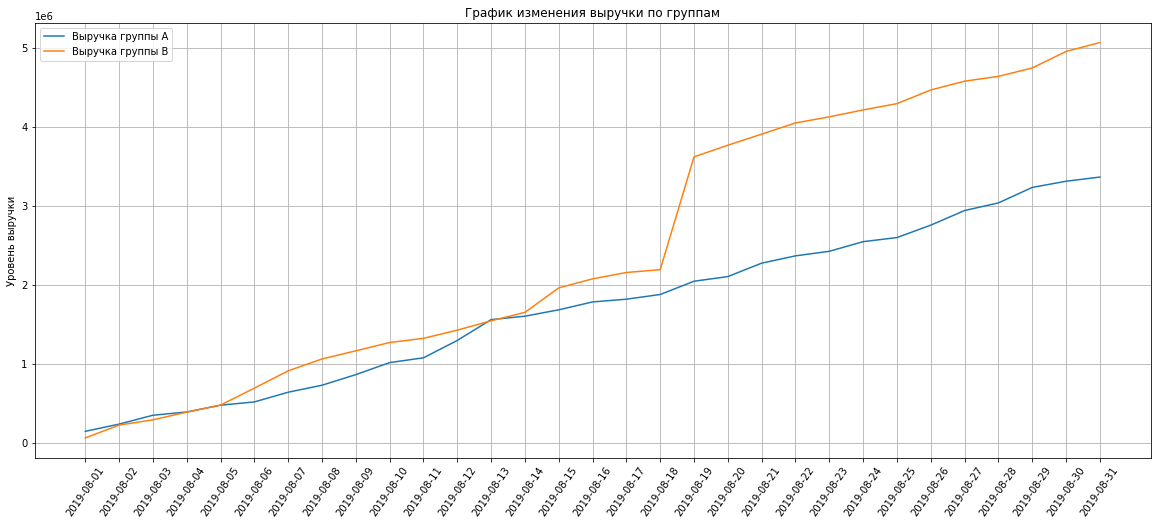

In [20]:
# Строим график выручки группы А
plt.plot(data['date'], data['revenueCummulativeA'], label='Выручка группы A')
# Строим график выручки группы B
plt.plot(data['date'], data['revenueCummulativeB'], label='Bыручка группы В')
plt.xticks(rotation=55)
plt.title('График изменения выручки по группам')
plt.ylabel('Уровень выручки')
plt.grid()
plt.legend()
plt.show()

### Выводы и предположения

Исходя из графика, группы А и Б по выручке не имели значимых расхождений, периодически сходясь в точках 5 и 13 августа, но после 13 августа группа Б стала несколько отрываться, 18 числа группа Б резко нарастила отрыв и уже не вернулась в прежние уровни, стабильно превосходя группу А примерно на 50%.

В силу того, что группа Б не имеет эсконенциального роста, я предполгагаю, что была привлечена некая новая, но ограниченная группа покупателей, либо прежней группе покупателей был предложен новый вид товаров, и данные новые группы отразились в графике увеличением денежного потока.

## Построим график кумулятивного среднего чека по группам, изучим, сделаем выводы и предположения

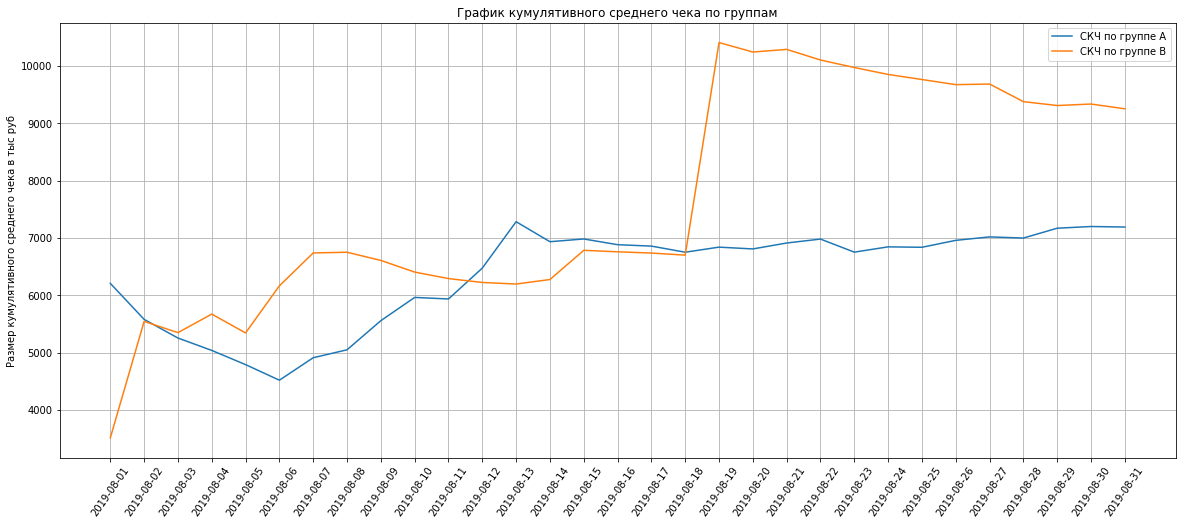

In [21]:
plt.plot(data['date'], data['revenueCummulativeA']/data['ordersCummulativeA'], label='СКЧ по группе A')
plt.plot(data['date'], data['revenueCummulativeB']/data['ordersCummulativeB'], label='СКЧ по группе В')
plt.xticks(rotation=55)     
plt.grid()
plt.title('График кумулятивного среднего чека по группам')
plt.ylabel('Размер кумулятивного среднего чека в тыс руб')
plt.legend()
plt.show()

### Выводы и предположения

Исходя из графика, группа А начала со снижения спроса, со значительным ростом ото дна 6 до пика 13 числа, после чего график стал плоским со слабой тенденцией к падению.

Группа Б начала с самых низких позиций, со слабыми провалами от вершин в точках 5 и 8 числа, с 15 числа перейдя в накопление и резко выстрелив 18 числа, со слабой тенденцией к снижению.

Исходя из графиков можно предположить, что на группу В повлияло некоторое событие, которое привлекло, а затем удержало значительную часть новых клиентов.

## Построим график относительного изменения кумулятивного среднего чека группы B к группе A, изучим, сделаем выводы и предположения

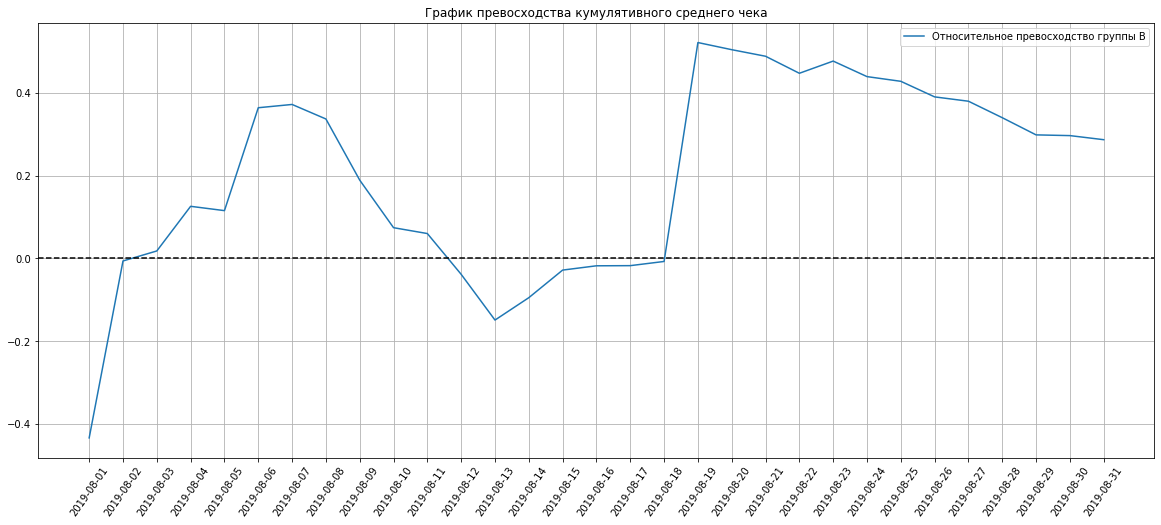

In [22]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = ordersACummulative.merge(ordersBCummulative, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], 
         (mergedCumulativeRevenue['revenueCummulativeB']/mergedCumulativeRevenue['ordersCummulativeB'])/
         (mergedCumulativeRevenue['revenueCummulativeA']/mergedCumulativeRevenue['ordersCummulativeA'])-1,
         label="Относительное превосходство группы В")

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.xticks(rotation=55)
plt.title('График превосходства кумулятивного среднего чека')
plt.legend()
plt.grid()

### Выводы и предположения

Есть две группы сильных выбросов с пиком в районе 7 и 19 чисел, и если первое не смогло устоять и падало ниже нулевого уровня, то второе удержало, пусть и с тенденцией к снижению. Существуют выбросы в виде новых покупаетелей, поднявших средний чек в группе В, и\или новые крупные заказы от старых покупателей, так же поднявшие средний чек. Нужно будет отсеять выбросы в дальнейшем.

## Построим график кумулятивного среднего количества заказов на посетителя по группам, изучим, сделаем выводы и предположения

In [23]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates() 

In [24]:
# агрегируем значения, вычислим максимальную дату, для группы тоже рассчитаем максимум, и хотя она будет определённой, 
# сделаем это, чтобы столбец 'group' не пропал из итогового вывода. Найдём число уникальных ID заказов и пользователей, 
# подсчитаем сумму средних чеков:
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [25]:
# аналогично получим агрегированные кумулятивные по дням данные о посетителях интернет-магазина: 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

### Объединим обе таблицы в одну и переименуем столбцы для большего удобства:

In [26]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

### Строим графики кумулятивных средних:

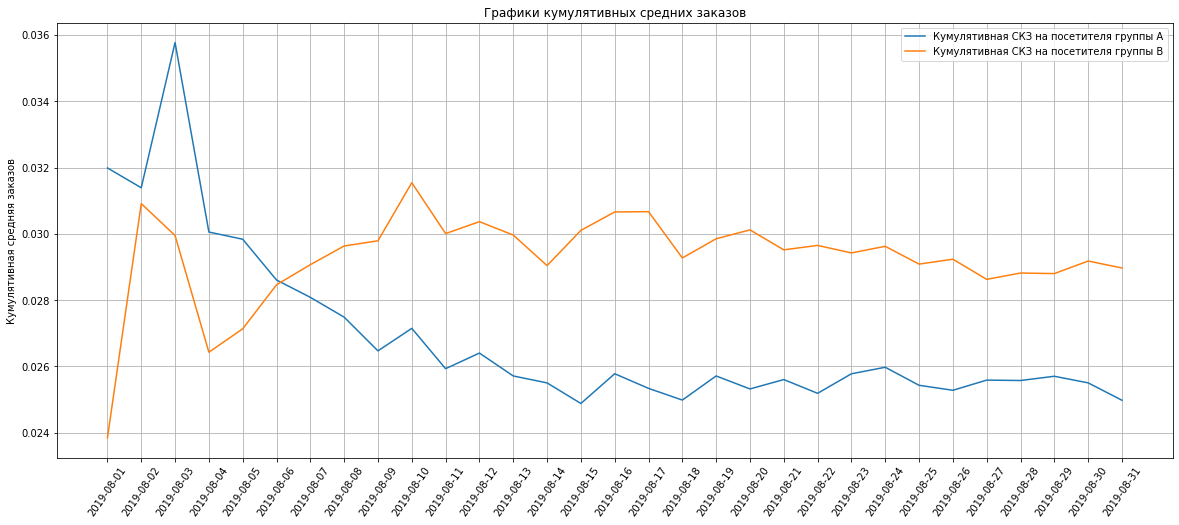

In [27]:
# считаем среднее количество заказов на посетителя
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label="Кумулятивная СКЗ на посетителя группы A" )
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='Кумулятивная СКЗ на посетителя группы B')
plt.xticks(rotation=55)
plt.title('Графики кумулятивных средних заказов')
plt.ylabel('Кумулятивная средняя заказов')
plt.legend()
plt.grid()

### Выводы и предположения

График среднего кумулятивного заказа (далее - СКЗ) группы А демонстрирует прежнее поведение - начало с лучших позиций, пик 3 числа, затем резкое и неуклонное падение с переходом в боковик после 10 числа с дальнейшей тенденцией к снижению.
СКЗ группы Б по-прежнему начинал с худших позиций, прошёл два пика в районе 10 и 17 числа (разница в неделю - привязка к выходным дням?), но не смог удержаться и тоже начал плавно падать. 

Так как пики и провалы двух групп асинхронны, рискну предположить, что продажи не были привязаны к датам, а привязаны к разным группам потребителей, отличающихся по полу и/или возрасту и/или материальному положению etc.

Настораживает, что во всех случаях обороты падают...

## Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A, изучим, сделаем выводы и предположения

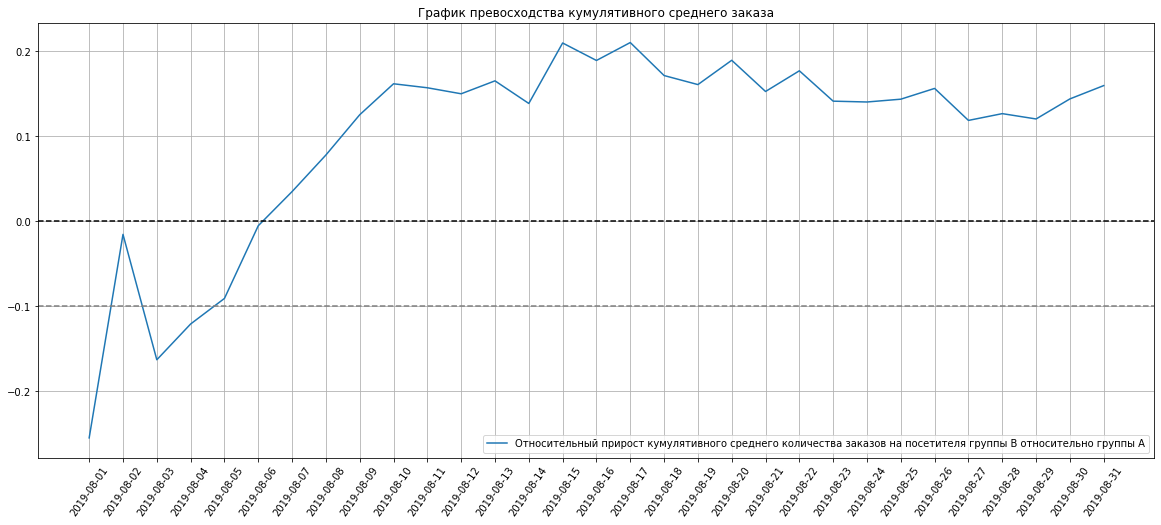

In [28]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост кумулятивного среднего количества заказов на посетителя группы B относительно группы A")
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.xticks(rotation=55)
plt.title('График превосходства кумулятивного среднего заказа')
plt.legend()
plt.grid()
plt.show()

### Выводы и предположения

Та же картина, пусть график и рисует повышение в конце, но это всего лишь означает, что СКЗ группы Б падает медленнее, чем у группы А.

## Построим точечный график количества заказов по пользователям, изучим, сделаем выводы и предположения

In [29]:
# подсчитаем количество заказов по всем пользователям
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)

ordersByUsers.columns = ['visitorId', 'orders']

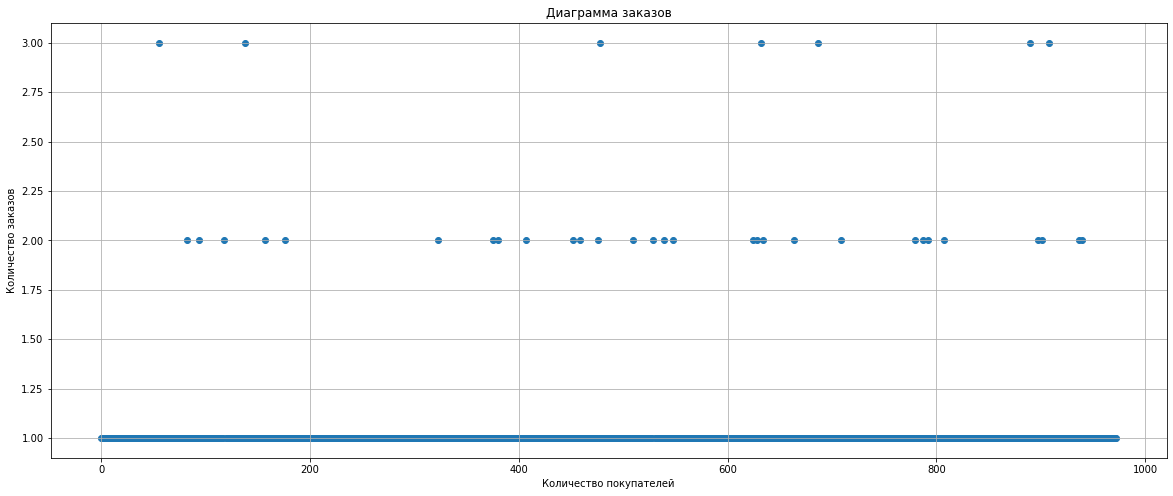

In [30]:
# построим точечную диаграмму числа заказов на одного пользователя
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders'])
plt.title("Диаграмма заказов")
plt.xlabel("Количество покупателей")
plt.ylabel("Количество заказов")
plt.grid()

Как видно из распределения, основная масса заказов приходится на единичные покупки, даже две и три составляют кратно меньшее количество.

### Выводы и предположения

Дорогие и/или многочисленные заказы настолько редки, что напрашивается вывод - причины надо искать в поведении человеческих групп.

## Посчитаем 95-й и 99-й перцентили количества заказов на пользователя, выберем границу для определения аномальных пользователей

In [31]:
# определим перцентили числа заказов
print(np.percentile(ordersByUsers['orders'], [90, 95, 99]))

[1. 1. 2.]


## Построим точечный график стоимостей заказов

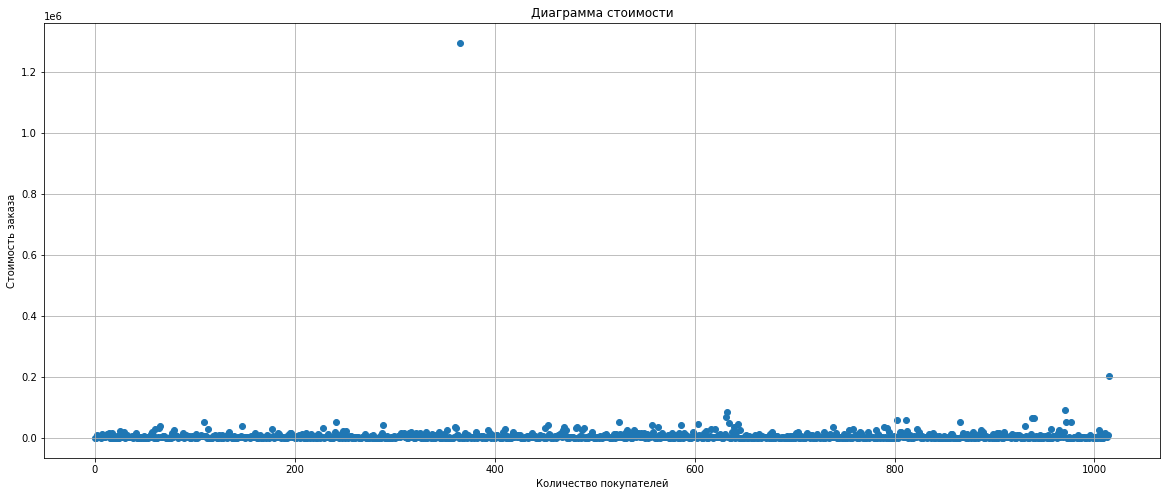

In [32]:
# строим график для изучения выбросов по исходным данным заказов и их стоимости
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.title("Диаграмма стоимости")
plt.xlabel("Количество покупателей")
plt.ylabel("Стоимость заказа")
plt.grid()

Как видно из графика, по-настоящему большой и выгодный суммарный заказ всего один.

## Посчитаем 95-й и 99-й перцентили стоимости заказов, выберем границу для определения аномальных заказов

In [33]:
# определим перцентили среднего чека
print(np.percentile(orders['revenue'], [90, 95, 99]))

[17990. 26785. 53904.]


<div class="alert alert-block alert-info">
#V1
    
При основной массе заказов в 17990 рублей - не более 5% заказов дороже 26785 рублей и не более 1% заказов дороже 53904 рублей.
 
Таким образом, границей отсечения является значение в 26785 рублей за один заказ.
</div>

## Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным, сделаем выводы и предположения

In [34]:
# cоздадим переменные ordersByUsersA и ordersByUsersB со столбцами ['userId', 'orders'], где для пользователей, которые 
# заказывали хотя бы 1 раз, укажем число совершённых заказов

ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders']

In [35]:
# объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов,
# запишем в них данные из фреймов ordersByUsersA и ordersByUsersB соотвественно

pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')

[ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')]

[0      1
 1      1
 2      1
 3      1
 4      1
       ..
 440    1
 441    1
 442    1
 443    1
 444    1
 Name: orders, Length: 445, dtype: int64,
 0        0
 1        0
 2        0
 3        0
 4        0
         ..
 18286    0
 18287    0
 18288    0
 18289    0
 18290    0
 Name: orders, Length: 18291, dtype: int64]

In [36]:
pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')

[ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')]

[0      1
 1      1
 2      1
 3      1
 4      1
       ..
 523    1
 524    1
 525    1
 526    1
 527    1
 Name: orders, Length: 528, dtype: int64,
 0        0
 1        0
 2        0
 3        0
 4        0
         ..
 18383    0
 18384    0
 18385    0
 18386    0
 18387    0
 Name: orders, Length: 18388, dtype: int64]

In [37]:
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

Сформулируем гипотезы:
    
Н0 - Нет различий в среднем количестве заказов между группами;
Н1 - Есть различия в среднем количестве заказов между группами.

In [38]:
# выведем относительный прирост среднего числа заказов группы B:
# среднее число заказов группы B / среднее число заказов группы A - 1, округлим до трёх знаков после запятой

print(f'Значение p-value: ' "{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print(f'Относительное превосходство группы В: ' "{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

Значение p-value: 0.011
Относительное превосходство группы В: 0.160


**Значение p-value=0.01 меньше alpha=0.05 - отвергаем нулевую гипотезу.

**Относительное превосходство группы B составляет 16%.

### Выводы и предположения

Исходя из альтернативной гипотезы, делаем предположение, что группа В совершает большее количество покупок.

## Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным

In [39]:
# Чтобы рассчитать статистическую значимость различий в среднем чеке, передадим критерию mannwhitneyu() данные о выручке
print(f'Значение p-value: ''{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print(f'Относительное превосходство группы В: ''{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

Значение p-value: 0.829
Относительное превосходство группы В: 0.287


Сформулируем гипотезы:

Н0 - Нет различий в среднем чеке между группами;
Н1 - Есть различия в среднем чеке между группами.

**Значение p-value=0.82 больше alpha=0.05 - не отвергаем нулевую гипотезу.

**Относительное превосходство группы B 28,7% не является значимым.

### Выводы и предположения

Так как нулевая гипотеза не отвергнута, считатаем, что различий в среднем чеке нет.

Отсюда можно предположить, что прирост выручки группы В произошёл за счёт количественного превосходства числа покупателей.

## Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

* Примем за аномальных пользователей тех, кто более 2 заказов или совершил заказ дороже 26 785 рублей. Так мы уберём 5% пользователей с наибольшим числом заказов и от 1% до 5% пользователей с дорогими заказами. Сделаем срезы пользователей с числом заказов больше 2 — "usersWithManyOrders" и пользователей, совершивших заказы дороже 26 785 — "usersWithExpensiveOrders". Объединим их в таблице "abnormalUsers". Узнаем, сколько всего аномальных пользователей применением атрибута "shape".

In [40]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['visitorId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['visitorId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 26785]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape[0])

568     113298937
1099    148427295
928     204675465
33      249864742
684     358944393
Name: visitorId, dtype: int64
58


Итого - 58 пользователей из покупающих часто и много.

In [41]:
# Посчитаем статистическую значимость различий в среднем количестве заказов между группами теста по очищенным данным,
# подготовим выборки количества заказов по пользователям по группам теста:

In [42]:
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))]['orders'],
pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders',),], axis=0,)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))]['orders'],
pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders',),], axis=0,)

Сформулируем гипотезы:
    
Н0 - Нет различий в очищенном среднем количестве заказов между группами;
Н1 - Есть различия в очищенном среднем количестве заказов между группами.

In [43]:
# Чтобы рассчитать статистическую значимость различий в среднем количестве, передадим критерию mannwhitneyu() данные о заказах
print(f'Значение p-value: ' '{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print(f'Относительное превосходство группы В: ' '{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

Значение p-value: 0.012
Относительное превосходство группы В: 0.182


**Значение p-value=0.01 меньше alpha=0.05 - отвергаем нулевую гипотезу.

**Относительное превосходство группы B 18,2% является значимым.

### Выводы и предположения

По уточнённым данным, группа В превосходит группу А по среднему количеству заказов на 18,2%.

## Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным 

Сформулируем гипотезы:
    
Н0 - Нет различий в очищенном среднем чеке заказа между группами;
Н1 - Есть различия в очищенном среднем чеке заказа между группами.

In [44]:
print(f'Значение p-value: ' '{0:.3f}'.format(stats.mannwhitneyu(orders[
np.logical_and(orders['group'] == 'A',
np.logical_not(orders['visitorId'].isin(abnormalUsers)),)]['revenue'],orders[np.logical_and(orders['group'] == 'B',
np.logical_not(orders['visitorId'].isin(abnormalUsers)),)]['revenue'],)[1]))

print(f'Относительное превосходство группы В: ' "{0:.3f}".format( orders[
np.logical_and(orders['group'] == 'B',              
np.logical_not(orders['visitorId'].isin(abnormalUsers)),)]['revenue'].mean()/ orders[
np.logical_and(orders['group'] == 'A',
np.logical_not(orders['visitorId'].isin(abnormalUsers)),)]['revenue'].mean()- 1))

Значение p-value: 0.646
Относительное превосходство группы В: -0.048


**Значение p-value=0.73 больше alpha=0.05 - не отвергаем нулевую гипотезу.

**Относительное превосходство в среднем чеке заказа группы А=0,04% не является значимым.

### Выводы и предположения

Так как нулевая гипотеза не отвергнута, считатаем, что по уточнённым данным различий в среднем чеке заказа нет.

# Решение по результатам теста

По "сырым" данным группа В превосходит группу А по количеству заказов, по уточнённым - также превосходит на приблизительные 18,2%.

По "сырым" данным группа В не превосходит группу А по среднему чеку, по уточнённым - по-прежнему не превосходит.

График различия СКЧ между группами сообщает, что результаты группы B лучше группы A: зафиксировались около среднего значения, но с лёгкой тенденцией к снижению.

График конверсии демонстрирует превосходство группы Б, но исключительно относительное - в абсолютных значениях оба имеют  тенденцию к снижению.

Тест остановлен, побеждает группа Б.

# Итоги

Согласно методике RICE были выбраны гипотезы:

7 - добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;
2 - добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа;
0 - добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей.

Так как во время тестирования было выявлено, что превосходства по среднему чеку между группами нет, но группа группа В превосходит группу А по количеству заказов, при том, что основное масса делает не более двух покупок внутри одного заказа, можно уверенно предположить, что преимущество обеспечено количественным превосходством членов группы В.

Исходя из вышеперечисленного, можно уверенно предположить, что стратегия по привлечению новых покупаетелей в виде гипотез 7 и 0 полностью оправдалась, гипотеза 2 не получила выраженного подтверждения.

Гипотезы проверялись на протяжении ограниченного количества времени - всего лишь 31 день, и говорить об устоявшейся тенденции нельзя.

Поведение всех групп демонстрирует тенденцию к затуханию спроса, из-за чего стратегия нуждается в пересмотре в сторону большей конверсии посетителей и/или расширении предложения для выбирания всей доступной покупательской способности среди существующей аудитории.